# Optiver Volatility EDA #

## Import Necessary Packages ##

In [1]:
import pyarrow.parquet as pq
import pyarrow as pa
import numpy as np
import pandas as pd
import os
import sys
import matplotlib.pyplot as plt

In [2]:
# Change Working Directory

os.chdir(r'C:\Users\Greg.Bone\Documents\GitHub\Optiver_Volatility')

# List All Book Folders ##

book_train_foldrs = os.listdir(r'Data\book_train.parquet')

## Define Necessary Functions

In [ ]:
## The Loss Function for this competition is the Root Mean Square Percentage Error. It is defined below
# predictions = vector of predicted values
# actuals = vector of training values

def RMSPE(predictions, actuals):
    np.sqrt(np.mean((predictions/actuals)-1))

## Get Data ##

### Get Trade Training Data

In [3]:
############################### Get Trade Training Data #######################################

os.chdir(r'C:\Users\Greg.Bone\Documents\GitHub\Optiver_Volatility')

trade_train_foldrs = os.listdir(r'Data\trade_train.parquet')

# Initialize list of trade tables #

trade_train_lst = []

for fldr in trade_train_foldrs:

    os.chdir(os.path.join(r'C:\Users\Greg.Bone\Documents\GitHub\Optiver_Volatility\Data\trade_train.parquet',fldr))
    fldr_file = os.listdir(os.getcwd())
    temp = pq.read_table(fldr_file, memory_map=True)
    temp_id = temp.append_column('stock_id', pa.array([str(fldr)] * len(temp), pa.string()))
    trade_train_lst.append(temp_id)

for tbl in range(0,len(trade_train_lst),1):
    trade_train_lst[tbl] = trade_train_lst[tbl].to_pandas()

trade_train = pd.concat(trade_train_lst, axis=0).reset_index(drop=True)

trade_train['stock_id'] = trade_train['stock_id'].str.replace('stock_id=','').astype('int32')

# get rid of list to save working memory #

del(trade_train_lst)

### Get Order Book Training Data ##

In [4]:
## Initialize List of Apache Tables ##

book_train_lst = []

for fldr in book_train_foldrs:

    os.chdir(os.path.join(r'C:\Users\Greg.Bone\Documents\GitHub\Optiver_Volatility\Data\book_train.parquet',fldr))
    fldr_file = os.listdir(os.getcwd())
    temp = pq.read_table(fldr_file, memory_map=True)
    temp_id = temp.append_column('stock_id', pa.array([str(fldr)] * len(temp), pa.string()))
    book_train_lst.append(temp_id)

for tbl in range(0,len(book_train_lst),1):
    book_train_lst[tbl] = book_train_lst[tbl].to_pandas()

book_train = pd.concat(book_train_lst, axis=0).reset_index(drop=True)

book_train['stock_id'] = book_train['stock_id'].str.replace('stock_id=','').astype('int32')

# get rid of list to save working memory #

del(book_train_lst)

### Get Target Variables

In [5]:
os.chdir(r'C:\Users\Greg.Bone\Documents\GitHub\Optiver_Volatility')

y_train = pd.read_csv(r"C:\Users\Greg.Bone\Documents\GitHub\Optiver_Volatility\Data\train.csv")
y_test = pd.read_csv(r"C:\Users\Greg.Bone\Documents\GitHub\Optiver_Volatility\Data\test.csv")

book_train = pd.merge(book_train, y_train, how='left', on = ['time_id','stock_id'])
trade_train = pd.merge(trade_train, y_train, how='left', on = ['time_id','stock_id'])

trade_train = trade_train.rename({'price':'trade_price','size':'trade_size'})


## Calculate Log Return and Realized Volatility for Later

### Get Log Return and Realized Volatility

In [6]:
def log_return(prices):

    log_return = np.log(prices).diff()

    return log_return

def realized_volatility(log_return):

    return np.sqrt(np.sum(log_return**2))

### Weighted Average Price, Log Return, and Realized Volatility Calculations

In [7]:
book_train['wap1'] = (book_train.bid_price1*book_train.ask_size1+book_train.ask_price1*book_train.bid_size1)/(book_train.bid_size1+book_train.ask_size1)
book_train['wap2'] = (book_train.bid_price2*book_train.ask_size2+book_train.ask_price2*book_train.bid_size2)/(book_train.bid_size2+book_train.ask_size2)

book_train.sort_values(['stock_id','time_id','seconds_in_bucket'])

book_train['log_return'] = log_return(book_train['wap1'])

rvol = book_train.groupby(['stock_id','time_id'])['log_return'].agg(realized_volatility).reset_index()
rvol = rvol.rename(columns={'log_return':'realized_volatility'})

## Inspect Initial Variables and Answer Some Questions?

### Visualize Volatility Across Different Stocks?

In [8]:
# We can't plot every stock, so let's pick six random ones and visualize their volatility and returns

stocks = np.random.choice(rvol.stock_id.unique(), size=6)

In [9]:
stocks_graphs = stocks

In [10]:
sgraph = pd.pivot_table(rvol.loc[rvol['stock_id'].isin(stocks_graphs),:].reset_index(), index='time_id',columns='stock_id', values='realized_volatility')

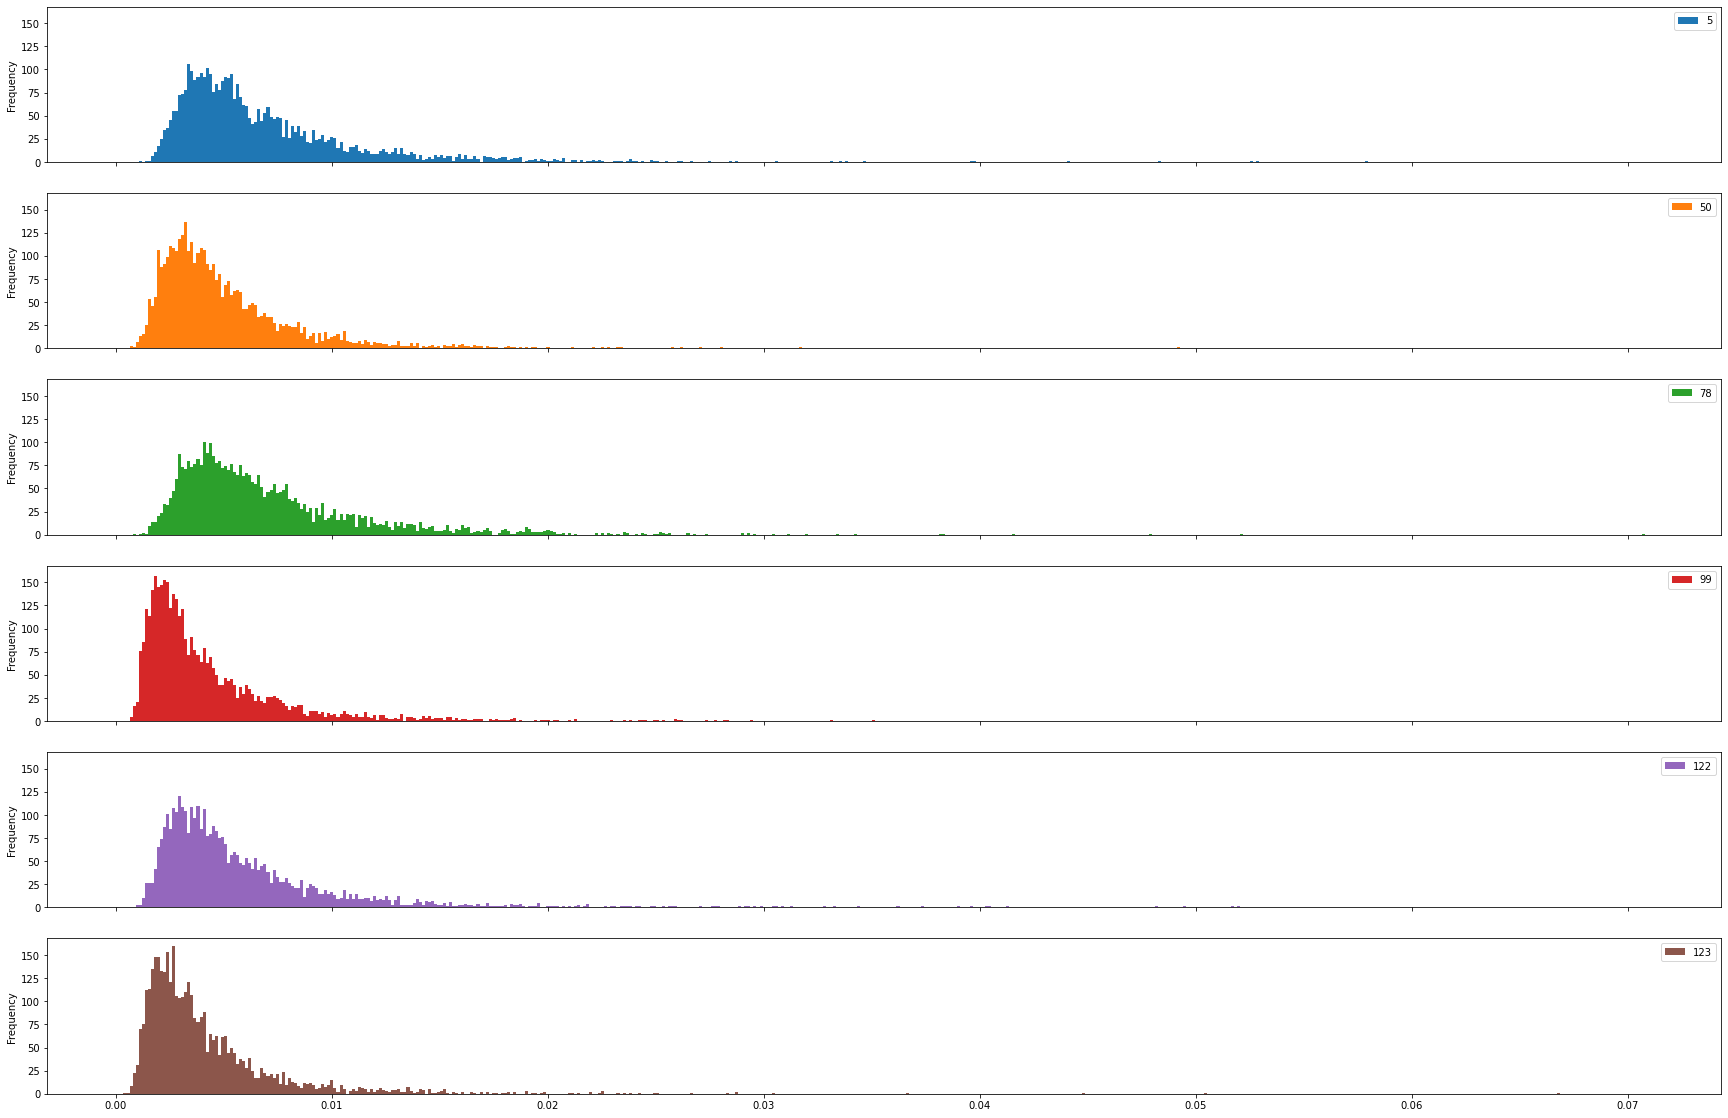

In [11]:
sgraph.plot(kind='hist', bins=500,subplots=True, sharex=True, sharey=True)
fig = plt.gcf()
fig.set_size_inches(30, 20)

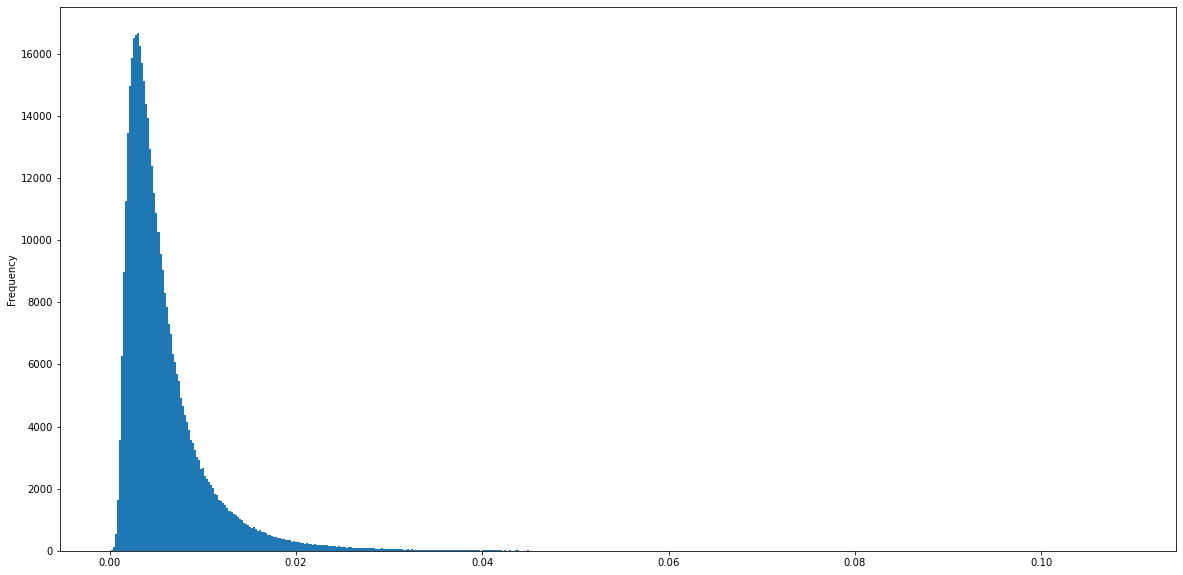

In [12]:
rvol['realized_volatility'].plot(kind='hist',bins=500)
fig = plt.gcf()
fig.set_size_inches(20, 10)

### Visualize Order Size Distribution Across Different Stocks

In [13]:
sizegraph = pd.pivot_table(trade_train.loc[trade_train['stock_id'].isin(stocks_graphs),:].reset_index(), index='time_id',columns='stock_id', values='size')

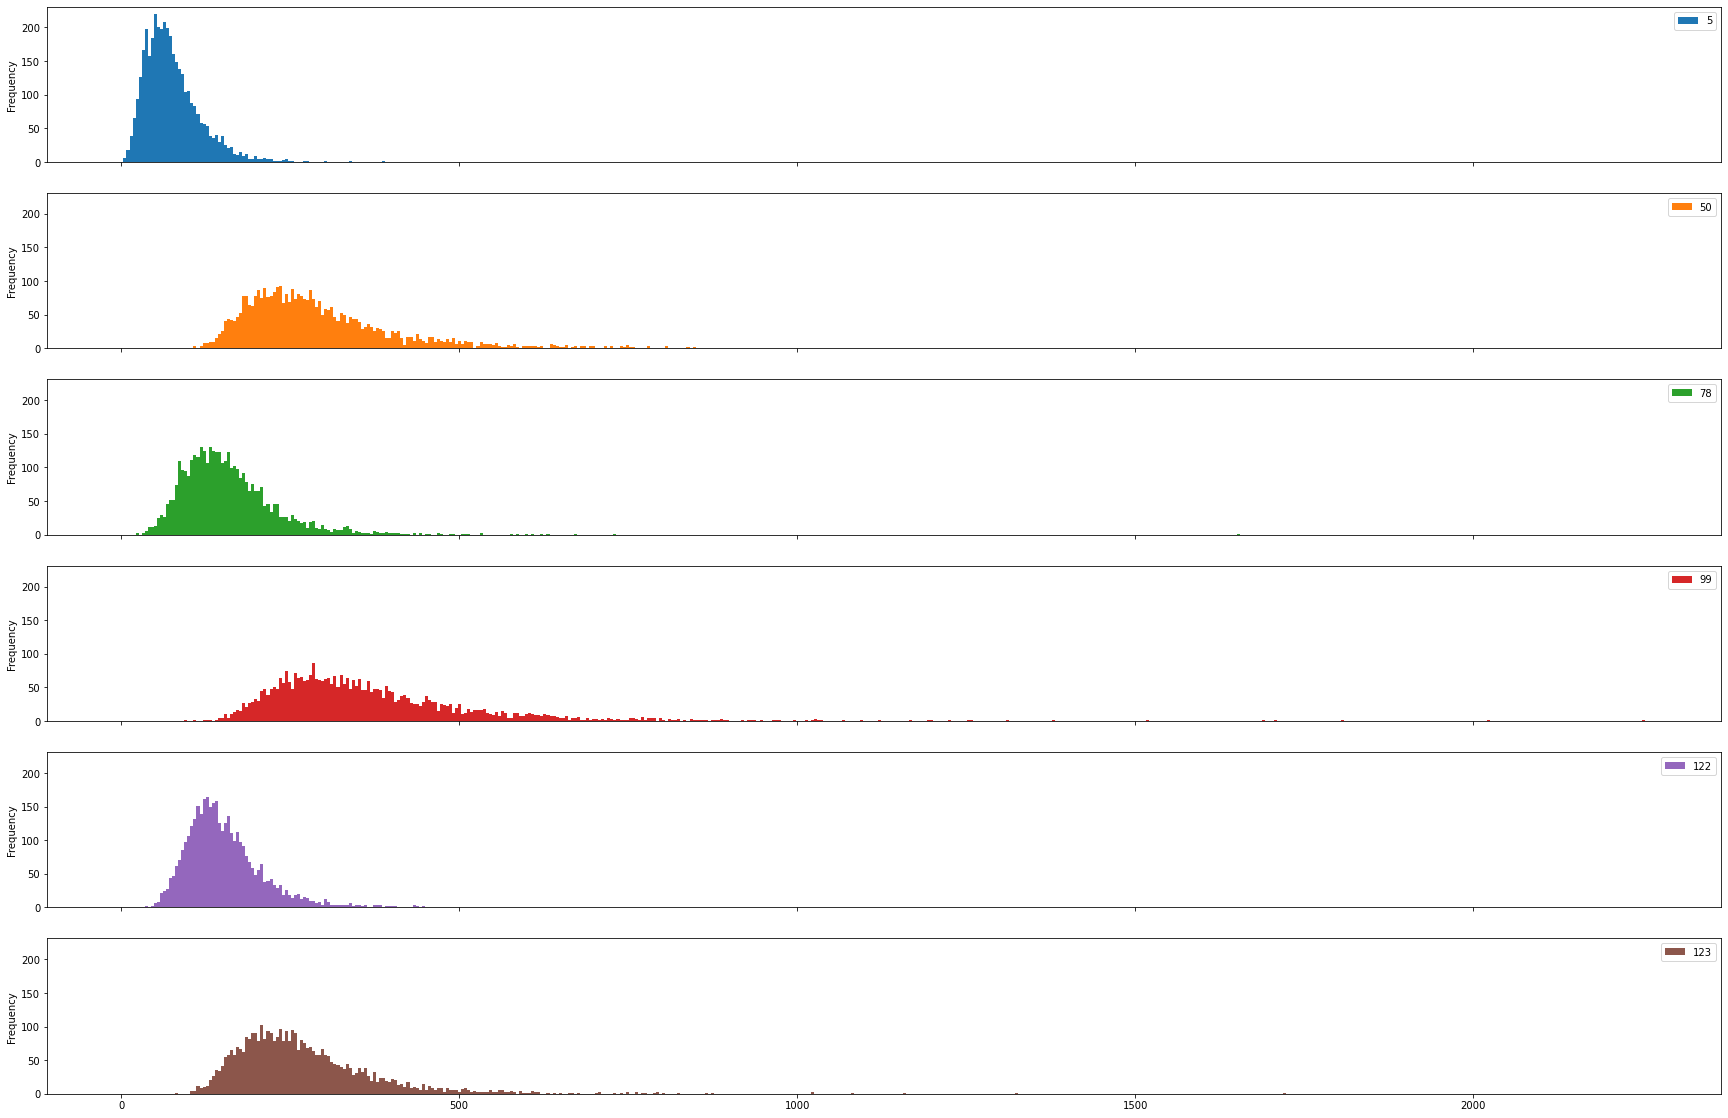

In [14]:
sizegraph.plot(kind='hist', bins=500,subplots=True, sharex=True, sharey=True)
fig = plt.gcf()
fig.set_size_inches(30, 20)

The distribution of each stock's order size varies much more than realized volatility. Let's do some feature engineering and see how those variables perform.

## Feature Engineering

In [18]:
# sort the data sets

trade_train = trade_train.sort_values(['stock_id','time_id','seconds_in_bucket'])
book_train = book_train.sort_values(['stock_id','time_id','seconds_in_bucket'])

### Trade Data

Time plays an important role in this data set. We are trying to predict the volatility of the next ten minutes for each stock based on the previous data. Lagged and differenced variables will be key to success in this competition. Let's create those variables in both the trade and order book data sets and visualize them to search for trends.

#### Let's Generate Some Variables and Examine Their Significance in the Data?

1. Lagged order count, price, and size for each stock_id and time_id
2. Sum of size and order count for each stock_id and time_id

In [67]:
## Lagged Order count, price, and size

trade_depvars = trade_train.groupby(['stock_id','time_id']).agg(total_count = ('order_count', sum), total_size = ('size', sum)).reset_index()

### Book Data

#### Let's Generate Some Variables and Examine Their Significance in the Data?

1. Average spread (bid_price1-ask_price1) by stock_id and time_id. Do the same for the second best price.
2. Lags of average spread
3. Weighted Average Price for the first and second best prices.
4. sum of bid and ask sizes for each stock_id and time_id
